<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Improvements-pursued-in-this-notebook" data-toc-modified-id="Improvements-pursued-in-this-notebook-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Improvements pursued in this notebook</a></span></li></ul></li><li><span><a href="#Multiclass-classifier-&amp;-train_n_sessions" data-toc-modified-id="Multiclass-classifier-&amp;-train_n_sessions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Multiclass classifier &amp; train_n_sessions</a></span><ul class="toc-item"><li><span><a href="#Tools-for-data,-model,-and-training" data-toc-modified-id="Tools-for-data,-model,-and-training-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Tools for data, model, and training</a></span></li><li><span><a href="#Train-model-once-w/-train_n_epochs" data-toc-modified-id="Train-model-once-w/-train_n_epochs-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Train model once w/ <code>train_n_epochs</code></a></span></li><li><span><a href="#Train-model-many-times-w/-train_n_sessions" data-toc-modified-id="Train-model-many-times-w/-train_n_sessions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Train model many times w/ <code>train_n_sessions</code></a></span><ul class="toc-item"><li><span><a href="#Diving-into-results-of-a-single-session" data-toc-modified-id="Diving-into-results-of-a-single-session-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Diving into results of a single session</a></span></li></ul></li><li><span><a href="#Train-model-w/-Learner" data-toc-modified-id="Train-model-w/-Learner-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Train model w/ <code>Learner</code></a></span><ul class="toc-item"><li><span><a href="#data" data-toc-modified-id="data-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>data</a></span></li><li><span><a href="#dataloaders" data-toc-modified-id="dataloaders-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>dataloaders</a></span></li><li><span><a href="#model" data-toc-modified-id="model-1.4.3"><span class="toc-item-num">1.4.3&nbsp;&nbsp;</span>model</a></span></li><li><span><a href="#Learner" data-toc-modified-id="Learner-1.4.4"><span class="toc-item-num">1.4.4&nbsp;&nbsp;</span>Learner</a></span></li></ul></li></ul></li></ul></div>

## Improvements pursued in this notebook

1. Change from binary classifier to multi category classifier:
    - add ims 0-9
    - add change loss fxn to cross entropy loss w/ softmax
    - change shape of final activation from 1 to 10
    - change label to 1HE
2. Add RGB

Super-short version with all of the helpers:

# Multiclass classifier & train_n_sessions

## Tools for data, model, and training

In [ ]:
from fastai.vision.all import *

### Data ###
def init_data(path, im_size, n_cls, batch_size):
    ## Train
    # ims
    for i in range(n_cls):
        new_ims = torch.stack(
            [tensor(Image.open(fn)) for fn in (path/'training'/f'{i}').ls()]
        ).float()/255
        if i == 0: ims = new_ims
        else: ims = torch.cat([ims,new_ims])
    train_ims = ims.view(-1,im_size)
    # lbls
    train_lbls = []
    for i in range(n_cls):
        l = L([0]*n_cls)
        l[i] = 1
        train_lbls += [l] * len((path/'training'/f'{i}').ls())    
    train_lbls = tensor(train_lbls)
    ## Valid
    # ims
    for i in range(n_cls):
        new_ims = torch.stack(
            [tensor(Image.open(fn)) for fn in (path/'testing'/f'{i}').ls()]
        ).float()/255
        if i == 0: ims = new_ims
        else: ims = torch.cat([ims,new_ims])
    valid_ims = ims.view(-1,im_size)
    # lbls
    valid_lbls = []
    for i in range(n_cls):
        l = L([0]*n_cls)
        l[i] = 1
        valid_lbls += [l] * len((path/'testing'/f'{i}').ls())    
    valid_lbls = tensor(valid_lbls)
    ## DataLoaders
    train_ds = L(zip(train_ims, train_lbls))
    valid_ds = L(zip(valid_ims, valid_lbls))
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
    return train_dl

### Model ###
def init_mod(im_size, n_cls, hidden_params):
    mod = nn.Sequential(
        nn.Linear(im_size,hidden_params),
        nn.ReLU(),
        nn.Linear(hidden_params,n_cls)
    )
    return mod

### Loss ###
def softmax(t):
    if len(t.shape) == 1: return torch.exp(t) / torch.exp(t).sum()
    else:                 return torch.exp(t) / torch.exp(t).sum(dim=1, keepdim=True)
def loss(yp, y):
    return (1 - (y*softmax(yp)).sum(dim=1, keepdim=True)).mean()  # softmax cross entropy loss

### Calculate gradients for use in train_once ###
def calc_grad(x,y,mod):
    yp = mod(x)     # get predictions
    ls = loss(yp,y) # calculate loss
    ls.backward()   # take gradient w.r.t. loss

### Create SGD Stepper; args = (mod.parameters(), lr) ###
class ParamStepper:
    def __init__(self, p, lr): self.p,self.lr = list(p),lr # initialize w/ mod.params & lr
        
    def step(self, *args, **kwargs):                       # take step
        for o in self.p: o.data -= o.grad.data * self.lr
            
    def zero_grad(self, *args, **kwargs):                  # reset grad
        for o in self.p: o.grad = None

### Train parameters by performing SGD on each mini-batch in the dl ###
def train_one_epoch(dl, mod, stepper):
    for xb,yb in dl:           # for every minibatch (xb,yb) in the dataloader:
        calc_grad(xb, yb, mod) # calc grad(loss(mod(xb),yb))
        stepper.step()         # take step
        stepper.zero_grad()    # reset grad

### Get accuracy of mod on a mini-batch ###
def mb_acc(yp,y):
    yp_max,yp_i = torch.max(yp, dim=1, keepdim=True)
    y_max, y_i  = torch.max(y,  dim=1, keepdim=True)
    return (yp_i==y_i).float().mean()
        
### Get accuracy of mod on a dataloader (takes avg of all mbs in dl) ###
def epoch_acc(dl, mod):
    a = [mb_acc(mod(xb), yb) for xb,yb in dl]
    return round(torch.stack(a).mean().item(), 5)          # avg acc over all mini-batches

### Run `train_once` `epochs` times given data `dl`, model `mod`, and stepper `stepper`
def train_n_epochs(dl, mod, stepper, nepochs):
    accs = L()
    for i in range(nepochs):
        print('.',end='')
        train_one_epoch(dl, mod, stepper)
        accs += epoch_acc(dl, mod)
    print('',end='\t')
    return accs

### Perform n training sessions ###
def train_n_sessions(dl, im_size, n_cls, hidden_params, nepochs, lr, nsessions):
    # accuracies and trained models are returned by train_n_sessions for access after training.
    accs = L()
    mods = L()
    # train model and record accs, mods
    print('Progress:',end='\n')
    for i in range(nsessions):
        print(i,end='')
        mod = init_mod(im_size, n_cls, hidden_params)
        stepper = ParamStepper(mod.parameters(), lr)
        accs += train_n_epochs(dl, mod, stepper, nepochs)
        mods += mod
    # restructure mods into nn.Sequential form for end-user convenience
    nmods = len(mods)
    trained_models = L()
    for n in range(nsessions):
        layers = L()
        for j in range(nmods//nsessions): layers.append(mods.pop())
        layers.reverse()
        seqmod = nn.Sequential(*layers.items)
        trained_models += [seqmod]
    print('Done')
    return accs, trained_models

## Train model once w/ `train_n_epochs`

In [ ]:
# params
path          = untar_data(URLs.MNIST)
n_cls         = 10
im_size       = 28*28
batch_size    = 64*2*2*2
hidden_params = 30
lr            = .1
nepochs       = 20

# inits
dl            = init_data(path, im_size, n_cls, batch_size)
mod           = init_mod(im_size, n_cls, hidden_params)
stepper       = ParamStepper(mod.parameters(), lr)

# train
train_n_epochs(dl, mod, stepper, nepochs)

....................	

(#20) [0.2564,0.40156,0.60688,0.71052,0.72864,0.73829,0.78658,0.8024,0.80999,0.81523...]

## Train model many times w/ `train_n_sessions`

In [ ]:
# params
path          = untar_data(URLs.MNIST)
n_cls         = 10
im_size       = 28*28
batch_size    = 64*2*2*2
hidden_params = 30
nepochs       = 30
lr            = .1
nsessions     = 4

# inits
# dl = init_data(path, im_size, n_cls, batch_size)

# train
accs,mods = train_n_sessions(dl, im_size, n_cls, hidden_params, nepochs, lr, nsessions)
accs_t = tensor(accs).reshape(nsessions,nepochs)

# print max acc
print("Max accuracy:",round(accs_t.max().item(),4))

# print training sessions
pd.DataFrame(accs_t.numpy())

Progress:
0..............................	1..............................	2..............................	3..............................	Done
Max accuracy: 0.918


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.20321,0.36224,0.64941,0.72600,0.78859,0.79937,0.80784,0.87557,0.88299,0.88825,...,0.91078,0.91226,0.91305,0.91460,0.91491,0.91579,0.91647,0.91694,0.91773,0.91803
1,0.28229,0.41783,0.55677,0.56697,0.72080,0.73564,0.74246,0.74530,0.74886,0.75083,...,0.76214,0.76183,0.76275,0.76358,0.76409,0.76411,0.76448,0.76473,0.76548,0.76562
2,0.29635,0.52273,0.59737,0.77249,0.80325,0.81428,0.82119,0.82421,0.82798,0.82920,...,0.84383,0.84389,0.84510,0.84530,0.84617,0.84669,0.84775,0.84849,0.84820,0.87624
3,0.39058,0.42651,0.64370,0.65673,0.66317,0.66713,0.73243,0.74230,0.74811,0.75052,...,0.76288,0.76335,0.76415,0.76439,0.76494,0.76504,0.76519,0.76547,0.76642,0.77723


### Diving into results of a single session

<AxesSubplot:>

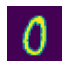

In [ ]:
xb,yb = list(dl)[0]
show_image(xb[0].view(28,28))

In [ ]:
yb[0]

In [ ]:
ypb = mods[0](xb)
softmax(ypb[0])

It thought the five was an 8.

In [ ]:
from fastai.vision.all import *

### Data ###
def init_data(path, im_size, n_cls, batch_size):
    ## Train
    # ims
    for i in range(n_cls):
        new_ims = torch.stack(
            [tensor(Image.open(fn)) for fn in (path/'training'/f'{i}').ls()]
        ).float()/255
        if i == 0: ims = new_ims # do this on first iter
        else:      ims = torch.cat([ims,new_ims]) # do this on all others
    train_ims = ims.view(-1,im_size)
    # lbls
    train_lbls = []
    for i in range(n_cls): train_lbls += [i] * len((path/'training'/f'{i}').ls())    
    train_lbls = tensor(train_lbls)
    ## Valid
    # ims
    for i in range(n_cls):
        new_ims = torch.stack(
            [tensor(Image.open(fn)) for fn in (path/'testing'/f'{i}').ls()]
        ).float()/255
        if i == 0: ims = new_ims
        else:      ims = torch.cat([ims,new_ims])
    valid_ims = ims.view(-1,im_size)
    # lbls
    valid_lbls = []
    for i in range(n_cls): valid_lbls += [i] * len((path/'testing'/f'{i}').ls())    
    valid_lbls = tensor(valid_lbls)
    ## DataLoaders
    train_ds = L(zip(train_ims, train_lbls))
    valid_ds = L(zip(valid_ims, valid_lbls))
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
    return train_dl

### Model ###
def init_mod(im_size, n_cls, hidden_params):
    mod = nn.Sequential(
        nn.Linear(im_size,hidden_params),
        nn.ReLU(),
        nn.Linear(hidden_params,n_cls)
    )
    return mod

### Loss ###
loss = F.cross_entropy
# def softmax(t):
#     if len(t.shape) == 1: return torch.exp(t) / torch.exp(t).sum()
#     else:                 return torch.exp(t) / torch.exp(t).sum(dim=1, keepdim=True)
# def loss(yp, y):
#     return (1 - (y*softmax(yp)).sum(dim=1, keepdim=True)).mean()

### Calculate gradients for use in train_once ###
def calc_grad(x,y,mod):
    yp = mod(x)     # get predictions
    ls = loss(yp,y) # calculate loss
    ls.backward()   # take gradient w.r.t. loss

### Create SGD Stepper; args = (mod.parameters(), lr) ###
class ParamStepper:
    def __init__(self, p, lr): self.p,self.lr = list(p),lr # initialize w/ mod.params & lr
        
    def step(self, *args, **kwargs):                       # take step
        for o in self.p: o.data -= o.grad.data * self.lr
            
    def zero_grad(self, *args, **kwargs):                  # reset grad
        for o in self.p: o.grad = None

### Train parameters by performing SGD on each mini-batch in the dl ###
def train_one_epoch(dl, mod, stepper):
    for xb,yb in dl:           # for every minibatch (xb,yb) in the dataloader:
        calc_grad(xb, yb, mod) # calc grad(loss(mod(xb),yb))
        stepper.step()         # take step
        stepper.zero_grad()    # reset grad

### Get accuracy of mod on a mini-batch ###
def mb_acc(yp,y):
    yp_max,yp_i = torch.max(yp, dim=1, keepdim=True)
    y_max, y_i  = torch.max(y,  dim=1, keepdim=True)
    return (yp_i==y_i).float().mean()
        
### Get accuracy of mod on a dataloader (takes avg of all mbs in dl) ###
def epoch_acc(dl, mod):
    a = [mb_acc(mod(xb), yb) for xb,yb in dl]
    return round(torch.stack(a).mean().item(), 5)          # avg acc over all mini-batches

### Run `train_once` `epochs` times given data `dl`, model `mod`, and stepper `stepper`
def train_n_epochs(dl, mod, stepper, nepochs):
    accs = L()
    for i in range(nepochs):
        print('.',end='')
        train_one_epoch(dl, mod, stepper)
        accs += epoch_acc(dl, mod)
    print('',end='\t')
    return accs

### Perform n training sessions ###
def train_n_sessions(dl, im_size, n_cls, hidden_params, nepochs, lr, nsessions):
    accs = L()
    mods = L()
    print('Progress:',end='\n')
    for i in range(nsessions):
        print(i,end='')
        mod = init_mod(im_size, n_cls, hidden_params)
        stepper = ParamStepper(mod.parameters(), lr)
        accs += train_n_epochs(dl, mod, stepper, nepochs)
        mods += mod
        
    # repack mods into nn.Sequential form
    nmods = len(mods)
    trained_models = L()
    for n in range(nsessions):
        layers = L()
        for j in range(nmods//nsessions): layers.append(mods.pop())
        layers.reverse()
        seqmod = nn.Sequential(*layers.items)
        trained_models += [seqmod]
        
    print('Done')
    return accs, trained_models

In [ ]:
# params
path          = untar_data(URLs.MNIST)
n_cls         = 10
im_size       = 28*28
batch_size    = 64*2*2*2
hidden_params = 30
lr            = .1
nepochs       = 20

# inits
dl            = init_data(path, im_size, n_cls, batch_size)
mod           = init_mod(im_size, n_cls, hidden_params)
stepper       = ParamStepper(mod.parameters(), lr)

# train
train_n_epochs(dl, mod, stepper, nepochs)

In [ ]:
xb,yb = list(dl)[0]

In [ ]:
yb.shape

In [ ]:
mod(xb).shape

In [ ]:
preds = -softmax(mod(xb))[range(batch_size),yb]

In [ ]:
F.cross_entropy(preds,yb)

In [ ]:
mod(xb).shape